# Shifting and scaling: general univariate Gaussians

Let $\tilde{x} \sim N(0, 1)$. In this section, we will shift $\tilde{x}$ by  $\mu \in R$, and scale it by $\sigma \in R^+$ in order to obtain a general univariate Gaussian $\tilde{z} \sim \mathcal{N}(\mu, \sigma^2)$.

The pdf of $\tilde{x}$ is $$p_{\tilde{x}}(x) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{x^2}{2}\right).$$

Let's plot the kernel density estimate (KDE) of $X$ by using a library function. In the following section, we will implement the KDE ourselves.

Here is the initial setup code where we import our libraries, and set up the random number generator (RNG) for reproducibility.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde

seed = 0
rng = np.random.RandomState(seed)
n = 10000

When plotting, it is good practice to create references to the figure and axis objects by calling `plt.subplots`. This will make it easy to overlay charts, and combine multiple plots in a grid if needed.

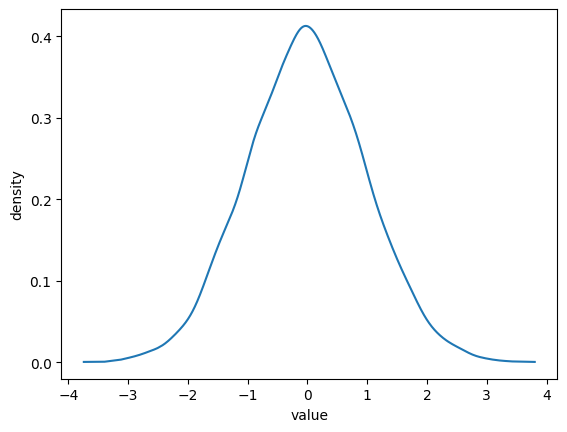

In [13]:
def plot_kde(ax, x, label):
    kde = gaussian_kde(x)
    x_sorted = np.sort(x)
    ax.plot(np.sort(x_sorted), kde(x_sorted), label=label)
    ax.set_xlabel("value")
    ax.set_ylabel("density")

fig, ax = plt.subplots(1, 1)

x = rng.normal(size=n)
plot_kde(ax, x, r"$p_{\tilde{x}}(x)$ estimate")

Let's compare the estimate to the ground truth.

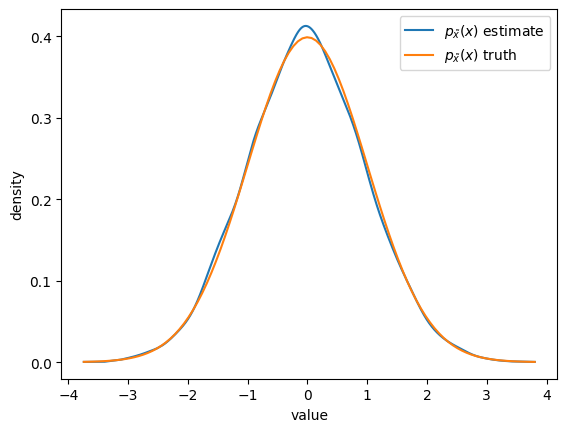

In [14]:
def pdf_x(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-(x ** 2 / 2))

x_range = np.linspace(x.min(), x.max(), 100)
ax.plot(x_range, pdf_x(x_range), label=r"$p_{\tilde{x}}(x)$ truth")
ax.legend()
fig

Now, let's shift $\tilde{x}$ by $\mu$ and call it $\tilde{y}$. That is, $\tilde{y} = \tilde{x} + \mu$. We can obtain the pdf of $\tilde{y}$ by substituting $\tilde{x} = \tilde{y} - \mu$ in the pdf of $\tilde{x}$. We have $$p_{\tilde{y}}(y) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(y - \mu)^2}{2}\right).$$

Let's compute the KDE of $\tilde{y}$, and compare it to the ground truth.

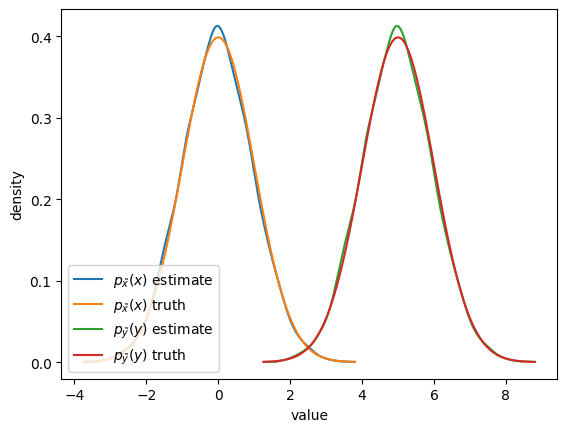

In [15]:
mu = 5
y = x + mu

def pdf_y(y, mu):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-((y - mu) ** 2 / 2))

plot_kde(ax, y, label=r"$p_{\tilde{y}}(y)$ estimate")
y_range = np.linspace(y.min(), y.max(), 100)
ax.plot(y_range, pdf_y(y_range, mu), label=r"$p_{\tilde{y}}(y)$ truth")
ax.legend()
fig

Finally, let's scale $\sigma$ to define $\tilde{z} = \sigma x + \mu$. Can we substitute $x = \frac{z - \mu}{\sigma}$ to obtain the pdf of $\tilde{z}$? This would be $$p'_{\tilde{z}}(z) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(z - \mu)^2}{2\sigma^2}\right).$$

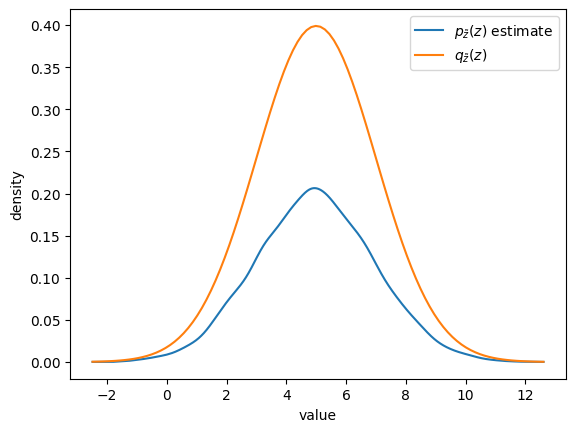

In [16]:
sigma = 2
z = sigma * x + mu

def qz(z, mu, sigma):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-((z - mu) ** 2 / (2 * sigma ** 2)))

figz, axz = plt.subplots(1, 1)
plot_kde(axz, z, label=r"$p_{\tilde{z}}(z)$ estimate")
z_range = np.linspace(z.min(), z.max(), 100)
axz.plot(z_range, qz(z_range, mu, sigma), label=r"$q_{\tilde{z}}(z)$")
axz.legend()

In this case, our KDE estimate and ground truth are inconsistent. What happened? We just scaled $\tilde{x}$ and plugged it back into $p_{\tilde{x}}(x)$ (after subtracting out $\mu$) to obtain $q_{\tilde{z}}(z)$. $q_{\tilde{z}}(z)$ is no longer a valid pdf, since it violates Theorem 3.18 by no longer integrating to one over its domain.

We can normalize $q_{\tilde{z}}(z)$ to turn it into $p_{\tilde{z}}(z)$, i.e. $$p_{\tilde{z}}(z) = \frac{1}{\sqrt{2\pi} \sigma} \exp\left(\frac{-(z - \mu)^2}{2 \sigma^2}\right).$$

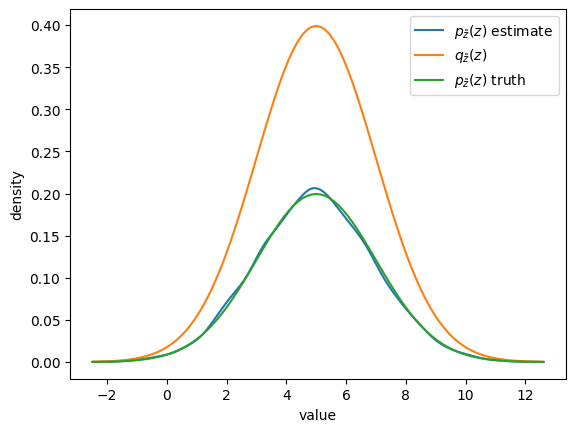

In [17]:
def pdf_z(z, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((z - mu) ** 2 / (2 * sigma ** 2)))

axz.plot(z_range, pdf_z(z_range, mu, sigma), label=r"$p_{\tilde{z}}(z)$ truth")
axz.legend()
figz

Let's see it alongside $\tilde{x}$ and $\tilde{y}$.

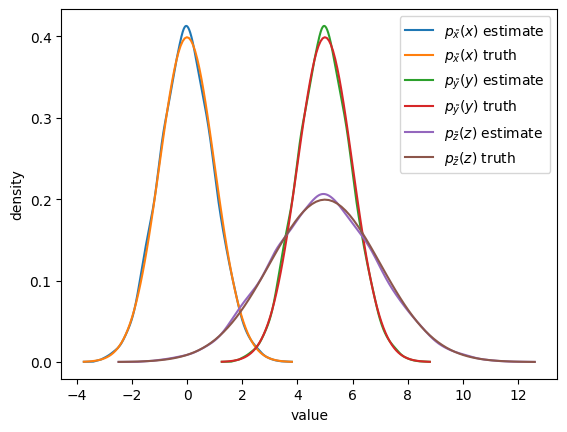

In [18]:
plot_kde(ax, z, label=r"$p_{\tilde{z}}(z)$ estimate")
ax.plot(z_range, pdf_z(z_range, mu, sigma), label=r"$p_{\tilde{z}}(z)$ truth")
ax.legend()
fig

# Implementing the Gaussian KDE

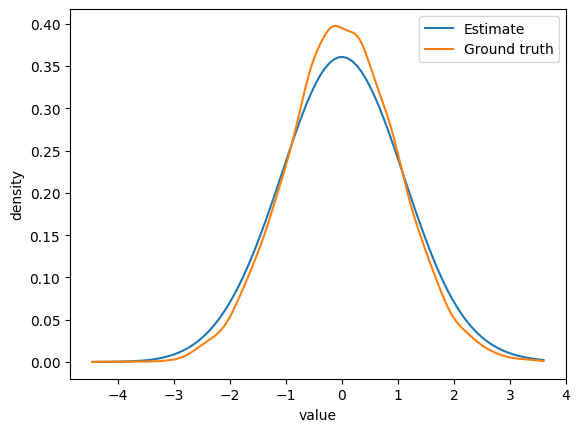

In [19]:
def plot_kde_truth(ax, x, label):
    kde = gaussian_kde(x)
    x_sorted = np.sort(x)
    ax.plot(np.sort(x_sorted), kde(x_sorted), label=label)

def gaussian_kernel(dist):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-dist**2 / 2)
    
x = rng.normal(size=n)

h = 0.5
a_range = np.linspace(x.min(), x.max(), 100)

kde_estimates = [gaussian_kernel((a - x) / h).sum() / (n * h) for a in a_range]
fig, ax = plt.subplots(1, 1)
ax.plot(a_range, kde_estimates, label="Estimate")
plot_kde(ax, x, "Ground truth")
ax.legend()

# Inverse transform sampling

It is very useful to be able to sample from a given distribution $\tilde{x} \sim p_{\tilde{x}}(x)$. Here we discuss a method called *inverse transform sampling* which transforms samples from $\mathcal{U}(0, 1)$ into samples from $p_{\tilde{x}}(x)$.

It assumes two things: (i) that we can sample from $\mathcal{U}(0, 1)$, and (ii) we can compute the inverse cdf of $\tilde{x}$ analytically.

Let's first consider the case where $\tilde{x} \sim \mathcal{U}(a, b)$. The CDF is $F_{\tilde{x}}(x) = \frac{x - a}{b - a}$. Therefore, the inverse cdf is $$\begin{align*}u &= \frac{x - a}{b - a}\\ u(b - a) &= x - a\\ x &= u(b - a) + a.\end{align*}$$

Here's the initial setup code.

In [20]:
u = rng.uniform(size=n)

def plot_samples(x_transformed, x_real):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].hist(x_transformed)
    axes[1].hist(x_real, color="orange")

    axes[0].set_title("Samples from inv cdf")
    axes[1].set_title("Samples from scipy")
    for ax in axes:
        ax.set_xlabel(r"$x$")
        ax.set_ylabel("Count")
    fig.tight_layout()

Let's sample from $\mathcal{U}(2, 5)$.

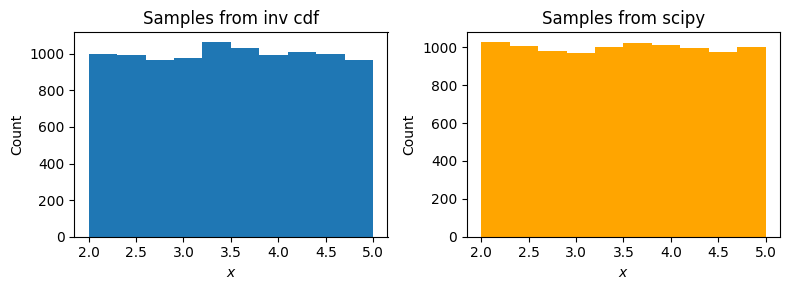

In [21]:
a, b = 2, 5

def inv_cdf(u, a, b):
    return u * (b - a) + a

x_transformed = inv_cdf(u, a, b)
x_real = rng.uniform(a, b, size=n)

plot_samples(x_transformed, x_real)

Next, let's consider the case where $\tilde{x}$ comes from an exponential distribution. The cdf is $F_{\tilde{x}}(x) = 1 - \exp(-\lambda x)$. To compute the inverse cdf, we can write
$$\begin{align*}u &= 1 - \exp(-\lambda x)\\ u - 1 &= \exp(-\lambda x)\\ 1 - u &= \exp(-\lambda x)\\ \ln(1 - y) &= \lambda x\\ x &= \frac{\ln(1 - y)}{-\lambda}\end{align*}.$$

This means that if we take $u \in [0, 1]$ as the output of the cdf, it gives us the value of $x$ such that $P(\tilde{x} \leq x) = u$.

Let's use this to sample from $\tilde{x} \sim \text{Exp}(1)$.

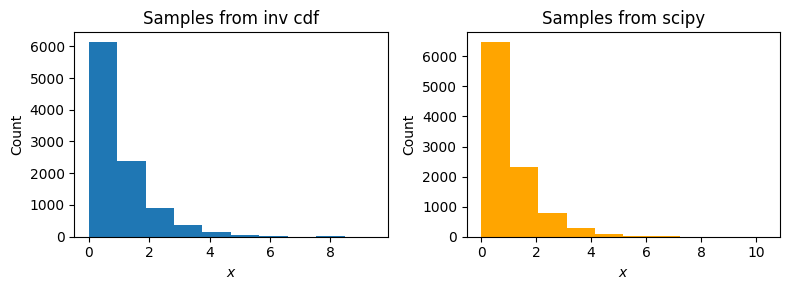

In [22]:
def inv_cdf_exp(u, lam):
    return np.log(1 - u) / -lam

lam = 1

x_transformed = inv_cdf_exp(u, lam)
x_real = rng.exponential(scale=lam, size=n)

plot_samples(x_transformed, x_real)